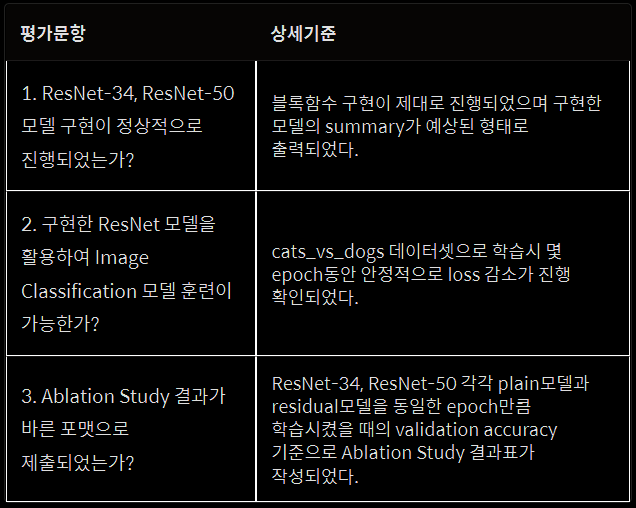

# 0. Libraries 및 Dataset 준비

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteXU1XLX/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
# feature 정보
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
print("Label의 수 = ", ds_info.features["label"].num_classes)

Label의 수 =  2


In [6]:
print("Label의 종류 = ", ds_info.features["label"].names)

Label의 종류 =  ['cat', 'dog']


In [7]:
# 데이터의 개수
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


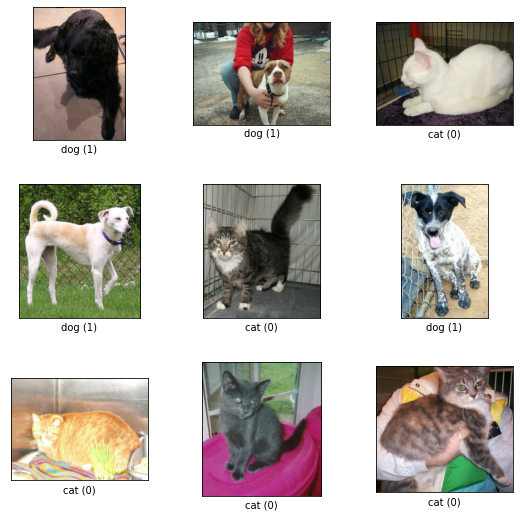

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

# 1. ResNet 기본 블록 구성하기

● **Deep Residual Learning for Image Recognition(He,CVPR 2016)**

  ▶ CNN에 비해 구조가 간단하면서 성능이 좋은 Residual learning을 제안였음    
  ▶ Layer가 많아지고 학습이 진행될수록 성능이 높은것을 확인할 수 있음    

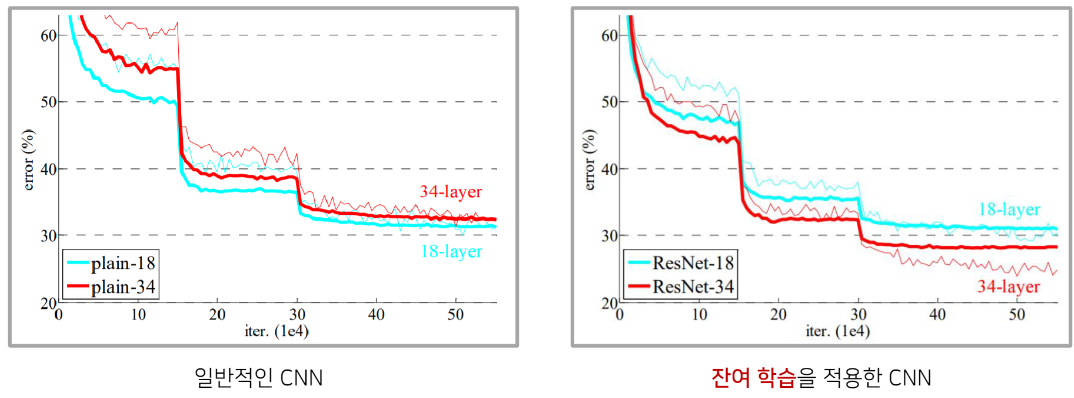

# 2. ResNet-34, ResNet-50 Complete Model

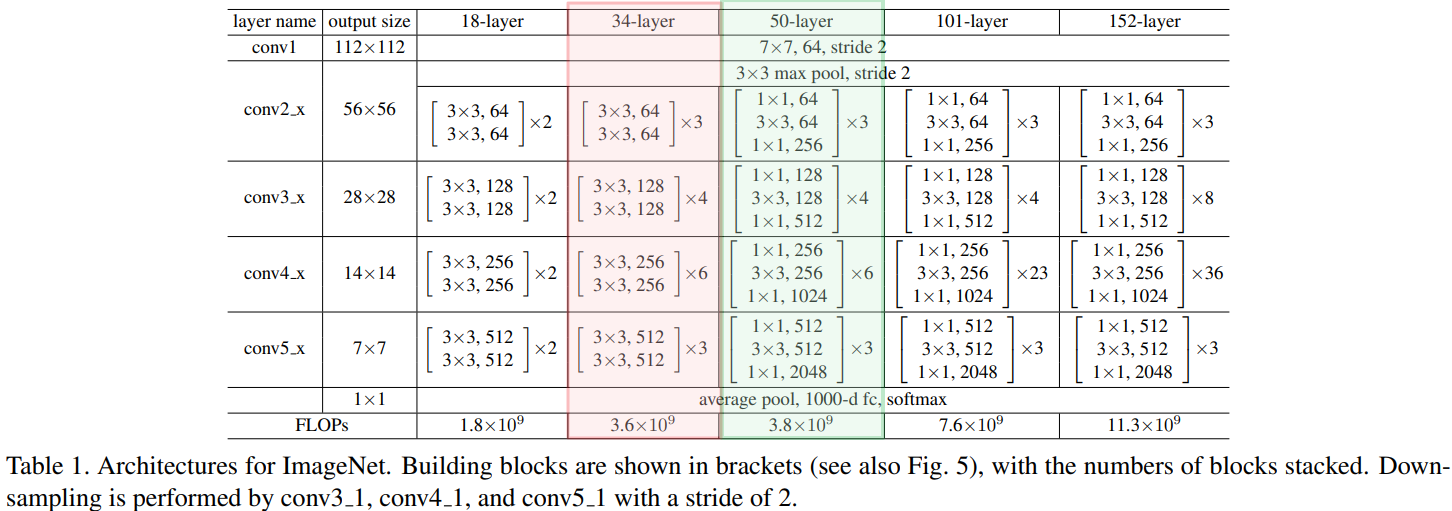

In [9]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    is_50=False, 
                    is_plain=False
                   ):
    x = input_layer

    shortcut = x

    if is_50:
        for i in range(num_cnn):
            if (i == 0):
                s = (2, 2)
                if block_num == 0:
                    s = (1, 1)    
                x = Conv2D(channel, (1,1), strides=s, padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(channel, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(channel*4, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)
                if is_plain:
                    x = Activation('relu')(x)
                else:
                    shortcut = Conv2D(channel*4, (1, 1), strides=s, padding='valid')(shortcut)            
                    shortcut = BatchNormalization()(shortcut)

                    x = Add()([x, shortcut])
                    x = Activation('relu')(x)

                    shortcut = x
            else:
                x = Conv2D(channel, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
                
                x = Conv2D(channel, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
    
                x = Conv2D(channel * 4, (1, 1), strides=(1, 1), padding='valid')(x)
                x = BatchNormalization()(x)            
                if is_plain:
                    x = Activation('relu')(x)
                else:  
                    x = Add()([x, shortcut])   
                    x = Activation('relu')(x)  
        
                    shortcut = x

    else:
        for i in range(num_cnn):
            if (i == 0):
                s = (2, 2)
                if block_num == 0:
                    s = (1, 1)    
                x = Conv2D(channel, (3, 3), strides=s, padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)

                x = Conv2D(channel, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                if is_plain:
                    x = Activation('relu')(x)
                else:
                    shortcut = Conv2D(channel, (1, 1), strides=s, padding='same')(shortcut)            
                    shortcut = BatchNormalization()(shortcut)

                    x = Add()([x, shortcut])
                    x = Activation('relu')(x)

                    shortcut = x
            else:
                x = Conv2D(channel, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
                
                x = Conv2D(channel, (3, 3), strides=(1, 1), padding='same')(x)
                x = BatchNormalization()(x)            
                if is_plain:
                    x = Activation('relu')(x)
                else:  
                    x = Add()([x, shortcut])   
                    x = Activation('relu')(x)  
        
                    shortcut = x
    return x

In [11]:
def build_resnet(input_shape=(32,32,3), num_classes=2, is_50=False, is_plain=False):
    num_cnn_list = [3,4,6,3]
    channel_list = [64,128,256,512]
    num_classes = num_classes

    input_layer = keras.layers.Input(shape=input_shape, name='input')
    output = input_layer
    
    output = ZeroPadding2D(padding=(3, 3))(output)
    output = keras.layers.Conv2D(
        filters=64, 
        kernel_size=(7,7),
        strides=2)(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    
    output = ZeroPadding2D(padding=(1, 1))(output)
    output = MaxPooling2D((3, 3), 2)(output)
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i,
            is_50 = is_50,
            is_plain=is_plain
        )
    output = GlobalAveragePooling2D()(output)
    output = Dense(num_classes, activation='softmax')(output)
    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )
    return model

In [12]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False, is_plain=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [13]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True, is_plain=False)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv2d_37 (Conv2D)             (None, 112, 112, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [14]:
resnet_34_plain = build_resnet(input_shape=(224, 224, 3), is_50=False, is_plain=True)
resnet_34_plain.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 230, 230, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_90 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_90 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 zero_padding2d_5 (ZeroPaddi  (None, 114, 114, 64)     0   

In [15]:
resnet_50_plain = build_resnet(input_shape=(224, 224, 3), is_50=True, is_plain=True)
resnet_50_plain.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_6 (ZeroPaddi  (None, 230, 230, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_123 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_123 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 zero_padding2d_7 (ZeroPaddi  (None, 114, 114, 64)     0   

# 4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [16]:
BATCH_SIZE = 32
EPOCH = 20

In [17]:
ds_train = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, True, BATCH_SIZE)

In [18]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 145s 202ms/step - loss: 0.6645 - accuracy: 0.6042 - val_loss: 0.7360 - val_accuracy: 0.5250
Epoch 2/20
581/581 [==============================] - 116s 200ms/step - loss: 0.6309 - accuracy: 0.6393 - val_loss: 0.6342 - val_accuracy: 0.6401
Epoch 3/20
581/581 [==============================] - 116s 200ms/step - loss: 0.6072 - accuracy: 0.6687 - val_loss: 0.6244 - val_accuracy: 0.6509
Epoch 4/20
581/581 [==============================] - 116s 199ms/step - loss: 0.5880 - accuracy: 0.6884 - val_loss: 0.6134 - val_accuracy: 0.6694
Epoch 5/20
581/581 [==============================] - 116s 199ms/step - loss: 0.5641 - accuracy: 0.7040 - val_loss: 0.6110 - val_accuracy: 0.6744
Epoch 6/20
581/581 [==============================] - 116s 199ms/step - loss: 0.5394 - accuracy: 0.7257 - val_loss: 0.5944 - val_accuracy: 0.6873
Epoch 7/20
581/581 [==============================] - 116s 199ms/step - loss: 0.5119 - accuracy: 0.7478 - val_loss: 0.6061 - val_accura

In [19]:
resnet_34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_plain = resnet_34_plain.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 124s 188ms/step - loss: 0.6976 - accuracy: 0.5465 - val_loss: 0.7100 - val_accuracy: 0.5034
Epoch 2/20
581/581 [==============================] - 109s 187ms/step - loss: 0.6863 - accuracy: 0.5600 - val_loss: 2.7499 - val_accuracy: 0.5159
Epoch 3/20
581/581 [==============================] - 109s 187ms/step - loss: 0.6705 - accuracy: 0.5915 - val_loss: 0.8528 - val_accuracy: 0.5356
Epoch 4/20
581/581 [==============================] - 108s 187ms/step - loss: 0.6538 - accuracy: 0.6193 - val_loss: 2.3285 - val_accuracy: 0.5097
Epoch 5/20
581/581 [==============================] - 108s 187ms/step - loss: 0.6462 - accuracy: 0.6252 - val_loss: 1.0259 - val_accuracy: 0.5315
Epoch 6/20
581/581 [==============================] - 108s 187ms/step - loss: 0.6372 - accuracy: 0.6359 - val_loss: 0.9299 - val_accuracy: 0.5597
Epoch 7/20
581/581 [==============================] - 108s 187ms/step - loss: 0.6249 - accuracy: 0.6494 - val_loss: 0.6363 - val_accura

In [20]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = 15,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 227s 356ms/step - loss: 0.7092 - accuracy: 0.5677 - val_loss: 0.7535 - val_accuracy: 0.5256
Epoch 2/15
581/581 [==============================] - 204s 352ms/step - loss: 0.6790 - accuracy: 0.6043 - val_loss: 0.7554 - val_accuracy: 0.5662
Epoch 3/15
581/581 [==============================] - 205s 352ms/step - loss: 0.6610 - accuracy: 0.6258 - val_loss: 0.7915 - val_accuracy: 0.5761
Epoch 4/15
581/581 [==============================] - 204s 352ms/step - loss: 0.6497 - accuracy: 0.6331 - val_loss: 0.7767 - val_accuracy: 0.5556
Epoch 5/15
581/581 [==============================] - 204s 351ms/step - loss: 0.6495 - accuracy: 0.6354 - val_loss: 0.8191 - val_accuracy: 0.5698
Epoch 6/15
581/581 [==============================] - 204s 351ms/step - loss: 0.6410 - accuracy: 0.6434 - val_loss: 0.7255 - val_accuracy: 0.5804
Epoch 7/15
581/581 [==============================] - 204s 351ms/step - loss: 0.6385 - accuracy: 0.6396 - val_loss: 0.8921 - val_accura

In [21]:
resnet_50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_plain = resnet_50_plain.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = 15,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 199s 311ms/step - loss: 0.7007 - accuracy: 0.5461 - val_loss: 0.9697 - val_accuracy: 0.5289
Epoch 2/15
581/581 [==============================] - 171s 294ms/step - loss: 0.7030 - accuracy: 0.5358 - val_loss: 0.8963 - val_accuracy: 0.5153
Epoch 3/15
581/581 [==============================] - 170s 293ms/step - loss: 0.7022 - accuracy: 0.5322 - val_loss: 7.2500 - val_accuracy: 0.5170
Epoch 4/15
581/581 [==============================] - 171s 294ms/step - loss: 0.7021 - accuracy: 0.5391 - val_loss: 3.6152 - val_accuracy: 0.4961
Epoch 5/15
581/581 [==============================] - 171s 294ms/step - loss: 0.6996 - accuracy: 0.5398 - val_loss: 1.5423 - val_accuracy: 0.4858
Epoch 6/15
581/581 [==============================] - 170s 293ms/step - loss: 0.6973 - accuracy: 0.5485 - val_loss: 0.6895 - val_accuracy: 0.5601
Epoch 7/15
581/581 [==============================] - 171s 294ms/step - loss: 0.6921 - accuracy: 0.5662 - val_loss: 1.1215 - val_accura

# 5. 시각화

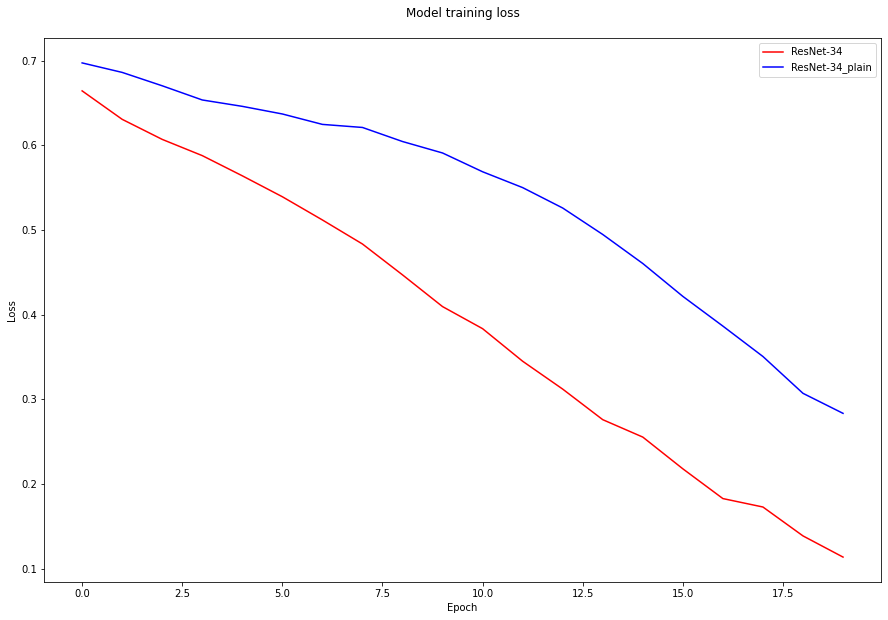

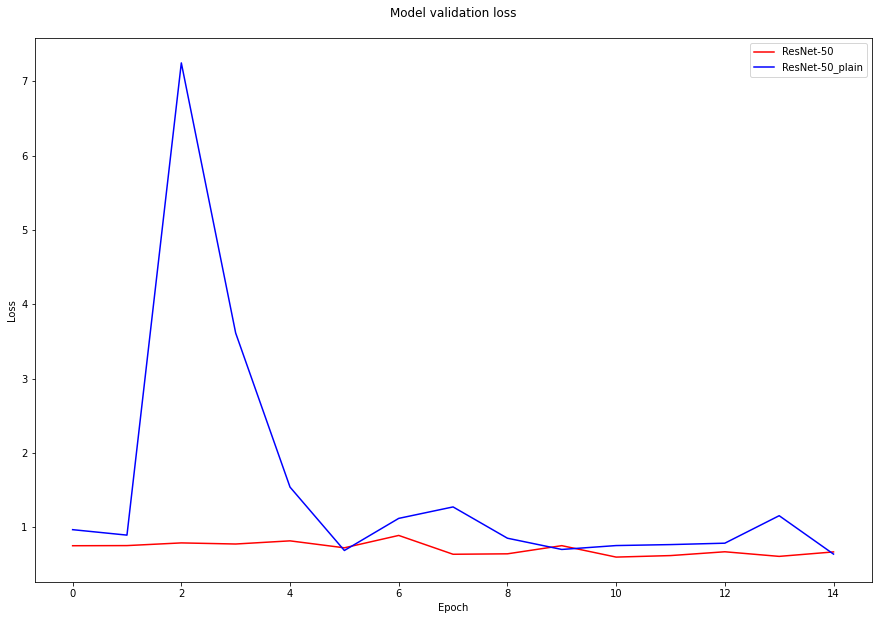

In [28]:
plt.figure(figsize=(15,10))
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_plain.history['loss'], 'b')
plt.title('Model training loss\n')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-34_plain'], loc='upper right')

plt.show()

plt.figure(figsize=(15,10))
plt.plot(history_50.history['val_loss'], 'r')
plt.plot(history_50_plain.history['val_loss'], 'b')
plt.title('Model validation loss\n')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'ResNet-50_plain'], loc='upper right')

plt.show()

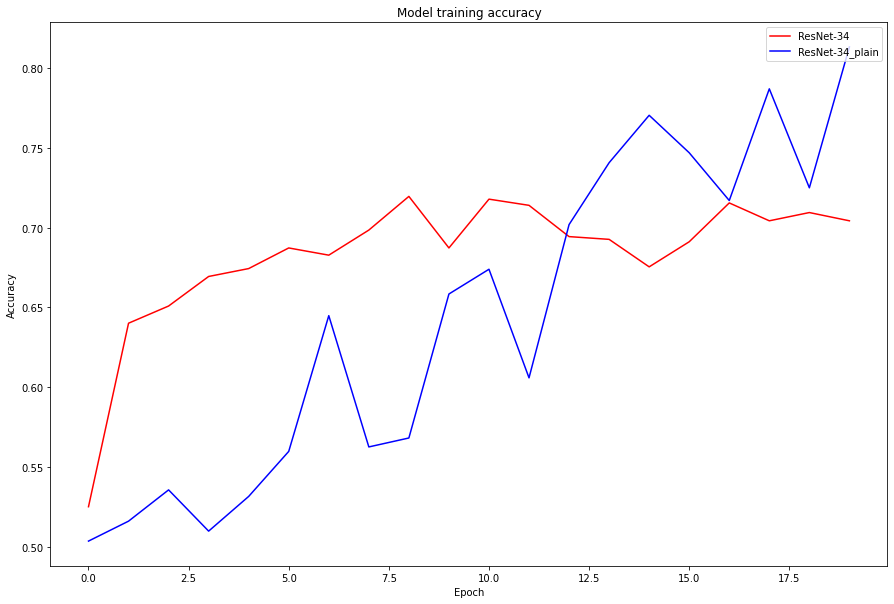

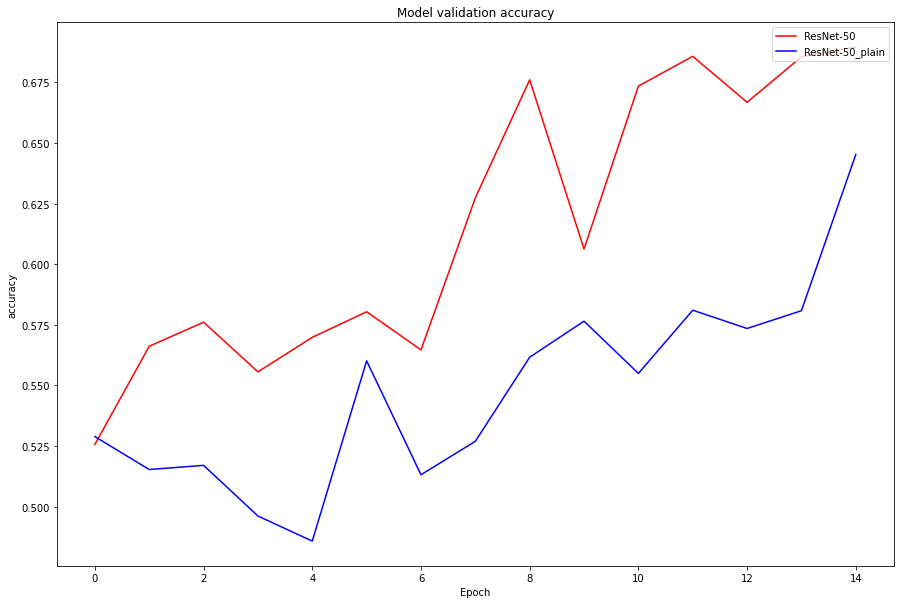

In [29]:
plt.figure(figsize=(15,10))
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_plain.history['val_accuracy'], 'b')
plt.title('Model training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-34_plain'], loc='upper right')

plt.show()

plt.figure(figsize=(15,10))
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_50_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'ResNet-50_plain'], loc='upper right')

plt.show()

# 6. 결과    
확실히 ResNet이 Plaing(No conection)보다 성능이 우수하였으며 epoch이 증가할 때마다 성능 증가 경향이 지속되었다. gradient descent문제의 개선이 확실히 유용한것을 확인할수 있었다. learning rate를 0.01로 하였었는데 0.001로 하여도 속도변화는 없는 것이 궁금하긴 하다.




# ※퇴고
이번거는 Exp에서 부족한 역량을 채우기 위해 논문과 블로그도 읽고 Youtube로 많은 영상을 읽어봄으로 이해력을 높이려고 노력하였다. 하지만 개념이해와 Coding은 다르다는 것을 강하게 깨달았으며 coding만 따로 공부하거나 현재 코딩마스터 하는데 좀더 많은 노력을 다짐하게 되었다. 해외 블로거를 참고하여 복사&붙어넣기가 아닌 직접 typing하면서 이해를 높이려고 하였으며 무사히 output을 뽑아냈었는데.... 정리하면서 Restart & Runn All하는데 오류가 발생하였다. coding하는거 면밀히 분석하고 변경하였는데도 실패하였었다. 어쩔수 없이 Aiffel에 다른분거를 그대로 복붙했는데도 동일한 오류가 발생하였다. 그러다가 새로운 colab파일을 생성하여 하였더니 잘되어서 이것으로 마무리하게 되었다. 하지만 learning 속도가 내가 한거에 비해 몇배는 느렸고 learning rate를 0.01로 하였는데도 속도는 동일하였다. 마감 시간이 얼마 남지 않아서 안타까울 따름이며 좀더 분발해야 겠다.